# Deep Learning to Model Claims Arrival Processes

### ACTL3143 
### Term 2 2022

## 1 Introduction

This notebook was originally an R notebook made by Meier and Schelldorfer et al (https://htmlpreview.github.io/?https://github.com/JSchelldorfer/ActuarialDataScience/blob/master/1%20-%20French%20Motor%20Third-Party%20Liability%20Claims/freMTPLfreq_glm.html) and was converted into Python for this course.

## 2 Data preparation

The tutorial uses the French MTPL data set available on openML (ID 41214).

### 2.1 Load packages and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 2.2 Set global parameters

In [2]:
# set seed to obtain best reproducibility
seed = 100

### 2.3 Helper functions

In [3]:
def poisson_deviance(pred, obs):
    return 200 * (sum(pred) - sum(obs) + sum(np.log((obs / pred) ** (obs)))) / len(pred)

In [4]:
#pmin function
from itertools import cycle
def pmin(l1, l2):
    a = []
    
    if type(l2) != "list":
        l2 = [l2]
    
    for i, j in zip(l1, cycle(l2)):
        a.append(min(i, j))
        
    return a

In [5]:
#Plot function
def plot_freq(test, xvar, title, model, mdlvariant):
    
    sum_out = test.groupby(xvar).agg(
        sum_claimNb = pd.NamedAgg(column = "ClaimNb", aggfunc = sum),
        sum_exposure = pd.NamedAgg(column = "Exposure", aggfunc = sum),
        sum_mdlvariant = pd.NamedAgg(column = mdlvariant, aggfunc = sum)
    )
    
    out = pd.DataFrame()
    out["obs"] = sum_out["sum_claimNb"] / sum_out["sum_exposure"]
    out["pred"] = sum_out["sum_mdlvariant"] / sum_out["sum_exposure"]
    
    plt.figure(figsize=(12,8))
    
    plt.plot(out.index, out["obs"], label = "observed")
    plt.plot(out.index, out["pred"], label = "GLM")
    plt.title(title)
    plt.xlabel(xvar)
    plt.ylabel("frequency")
    plt.legend()
    plt.show()

### 2.4 Load data

We consider the data freMTPL2freq included in the R package CASdatasets for claim frequency modeling. This data comprises a French motor third-party liability (MTPL) insurance portfolio with corresponding claim counts observed in one accounting year. We do not incorporate claim sizes which would also be available through freMTPL2sev.

As the current package version provides a slightly amended dataset, we use an older dataset available on openML (ID 41214). Before we can use this data set we need to do some data cleaning. It has been pointed out by F. Loser that some claim counts do not seem to be correct. Hence, we use the pre-processing of the data described in the book "Statistical Foundations of Actuarial Learning and its Applications" in Appendix A.1. This processed data was converted to csv for use in ACTL3143. 

In [6]:
freMTPL2freq = pd.read_csv("data/freMTPL2freq.csv", index_col = 0)

In [7]:
freMTPL2freq.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb
1,1.0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0
2,3.0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0
3,5.0,0.75,B,6,2,52,50,B12,Diesel,54,R22,0.0,0
4,10.0,0.09,B,7,0,46,50,B12,Diesel,76,R72,0.0,0
5,11.0,0.84,B,7,0,46,50,B12,Diesel,76,R72,0.0,0


### 2.5 General data preprocessing

A priori, there is not sufficient information about this data to do a sensible decision about the best consideration of the exposure measure, either as feature or as offset. In the following we treat the exposure always as an offset.

Data preprocessing includes a couple of transformations. We ensure that ClaimNb is an integer, VehAge, DrivAge and BonusMalus have been capped for the plots at age 20, age 90 and bonus-malus level 150, respectively, to improve visualization. Density is logarithmized and VehGas is a categorical variable. We leave away the rounding used in the first notebook, which were mainly used for nicer visualizations of the data.

We are adding a group_id identifying rows possibly referring to the same policy. Respecting group_id in data splitting techniques (train/test, cross-validation) is essential. This is different to the tutorial where another splitting has been used. As a consequence, the figures in this notebook do not match the figures in the tutorial, but the conclusions drawn are the same.

In addition to the previous tutorial, we decide to truncate the ClaimNb and the $ in order to correct for unreasonable data entries and simplifications for the modeling part.

In [8]:
# Grouping id
subset = list(freMTPL2freq.columns)

subset.remove("IDpol")
subset.remove("Exposure")
subset.remove("ClaimNb")

distinct = freMTPL2freq.drop_duplicates(subset = subset)
distinct = distinct.drop(["IDpol", "Exposure", "ClaimNb"], axis = 1)

In [9]:
distinct["Group_id"] = distinct.reset_index().index + 1

In [10]:
dat = freMTPL2freq.merge(distinct, on = ["Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region", "ClaimTotal"])

In [11]:
#Cap values of certain variables
dat["ClaimNb"] = pmin(dat["ClaimNb"], 4)
dat["VehAge"] = pmin(dat["VehAge"], 20)
dat["DrivAge"] = pmin(dat["DrivAge"], 90)
dat["Density"] = round(np.log(dat["Density"]), 2)
dat["Exposure"] = pmin(dat["Exposure"], 1)

In [12]:
dat.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,Group_id
0,1.0,0.10,D,5,0,55,50,B12,Regular,7.10,R82,0.0,0,1
1,3.0,0.77,D,5,0,55,50,B12,Regular,7.10,R82,0.0,0,1
2,5.0,0.75,B,6,2,52,50,B12,Diesel,3.99,R22,0.0,0,2
3,10.0,0.09,B,7,0,46,50,B12,Diesel,4.33,R72,0.0,0,3
4,11.0,0.84,B,7,0,46,50,B12,Diesel,4.33,R72,0.0,0,3


In [13]:
#Group sizes of suspected clusters
dat.groupby("Group_id").count()["IDpol"].value_counts()

1     429576
2      84201
3      13940
4       2437
5        966
6        754
7        720
8        475
9        400
10       269
12       191
11       142
13         3
15         2
14         1
22         1
18         1
Name: IDpol, dtype: int64

### 2.6 Feature pre-processing for generalized linear models

As previously mentioned, typically features $x_i$ need pre-processing before being used for a specific model. In our Poisson GLM the regression function is modeled by a log-linear shape in the continuous feature components. From the marginal empirical frequency plots in the previous file we see that such a log-linear form is not always appropriate. We make the following choices here:

- $\texttt{Area}$: we choose a continuous (log-linear) feature component for $\{A,...,F\}$ $\mapsto$ $\{1,...,6\}$
- $\texttt{VehPower}$: we choose a categorical feature component where we merge vehicle power groups bigger and equal to 9 (totally 6 classes)
- $\texttt{VehAge}$: we build 3 categorical classes $[0,1), [1,10], (10,\infty)$
- $\texttt{DrivAge}$: we build 7 categorical classes $[18,21), [21,26), [26,31), [31,41), [41,51), [51,71),
[71,\infty)$
- $\texttt{BonusMalus}$: continuous log-linear feature component (we cap at value 150)
- $\texttt{VehBrand}$: categorical feature component (totally 11 classes)
- $\texttt{VehGas}$: binary feature component;
- $\texttt{Density}$: log-density is chosen as continuous log-linear feature component (note that we
have very small volumes for small log-densities)
- $\texttt{Region}$: categorical feature component (totally 22 classes)

Thus, we consider 3 continuous feature components ($\texttt{Area}$, $\texttt{BonusMalus}$, $\texttt{log-Density}$), 1 binary feature component ($\texttt{VehGas}$) and 5 categorical feature components ($\texttt{VehPower}$, $\texttt{VehAge}$, $\texttt{DrivAge}$, $\texttt{VehBrand}$, $\texttt{Region}$). The categorical classes for $\texttt{VehPower}$, $\texttt{VehAge}$ and $\texttt{DrivAge}$ have been done based on expert opinion, only. This expert opinion has tried to find homogeneity within class labels (levels) and every class label should receive a sufficient volume (of observations). We could also make a data-driven choice by using a (marginal) regression tree for different feature components, see references in the tutorial.

In [14]:
dat2 = dat

dat2["AreaGLM"] = dat["Area"]
dat2["VehPowerGLM"] = pmin(dat["VehPower"], 9)
dat2["VehPowerGLM"] = dat2["VehPowerGLM"].astype("category")
dat2["VehAgeGLM"] = pd.cut(dat["VehAge"], [np.NINF, 0, 10, np.inf], labels = ["1", "2", "3"])
dat2["DrivAgeGLM"] = pd.cut(dat["DrivAge"], [np.NINF, 20, 25, 30, 40, 50, 70, np.inf], labels = ["1", "2", "3", "4", "5", "6", "7"])
dat2["BonusMalusGLM"] = pmin(dat["BonusMalus"], 150)
dat2["DensityGLM"] = dat["Density"]

## 2.7 Inspect the prepared dataset

In [15]:
dat2.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,Group_id,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
0,1.0,0.10,D,5,0,55,50,B12,Regular,7.10,R82,0.0,0,1,D,5,1,6,50,7.10
1,3.0,0.77,D,5,0,55,50,B12,Regular,7.10,R82,0.0,0,1,D,5,1,6,50,7.10
2,5.0,0.75,B,6,2,52,50,B12,Diesel,3.99,R22,0.0,0,2,B,6,2,6,50,3.99
3,10.0,0.09,B,7,0,46,50,B12,Diesel,4.33,R72,0.0,0,3,B,7,1,5,50,4.33
4,11.0,0.84,B,7,0,46,50,B12,Diesel,4.33,R72,0.0,0,3,B,7,1,5,50,4.33


In [16]:
dat2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678007 entries, 0 to 678006
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   IDpol          678007 non-null  float64 
 1   Exposure       678007 non-null  float64 
 2   Area           678007 non-null  object  
 3   VehPower       678007 non-null  int64   
 4   VehAge         678007 non-null  int64   
 5   DrivAge        678007 non-null  int64   
 6   BonusMalus     678007 non-null  int64   
 7   VehBrand       678007 non-null  object  
 8   VehGas         678007 non-null  object  
 9   Density        678007 non-null  float64 
 10  Region         678007 non-null  object  
 11  ClaimTotal     678007 non-null  float64 
 12  ClaimNb        678007 non-null  int64   
 13  Group_id       678007 non-null  int64   
 14  AreaGLM        678007 non-null  object  
 15  VehPowerGLM    678007 non-null  category
 16  VehAgeGLM      678007 non-null  category
 17  DrivAgeGLM

In [17]:
dat2.describe()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimTotal,ClaimNb,Group_id,BonusMalusGLM,DensityGLM
count,6.780070e+05,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,6.780070e+05,678007.000000,678007.000000,678007.000000,678007.000000
mean,2.621857e+06,0.528547,6.454653,6.976077,45.496811,59.761588,5.981576,8.816661e+01,0.038910,275320.005438,59.757297,5.981576
std,1.641789e+06,0.364081,2.050902,5.398963,14.129919,15.636700,1.870569,5.822068e+03,0.204688,152464.742969,15.607948,1.870569
min,1.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,0.000000,0.000000e+00,0.000000,1.000000,50.000000,0.000000
25%,1.157948e+06,0.180000,5.000000,2.000000,34.000000,50.000000,4.520000,0.000000e+00,0.000000,149318.500000,50.000000,4.520000
50%,2.272153e+06,0.490000,6.000000,6.000000,44.000000,50.000000,5.970000,0.000000e+00,0.000000,273211.000000,50.000000,5.970000
75%,4.046278e+06,0.990000,7.000000,11.000000,55.000000,64.000000,7.410000,0.000000e+00,0.000000,404071.500000,64.000000,7.410000
max,6.114330e+06,1.000000,15.000000,20.000000,90.000000,230.000000,10.200000,4.075401e+06,4.000000,534079.000000,150.000000,10.200000


# 3 Modeling

With the prepared dataset ready, we are ready for the modeling part.

One of the frequent mistakes is to do the pre-processing after the split or inconsistently between various model to be compared. This results in not a fair comparison of the model performance.

In the following, we will fit various claim frequency models based on a Poisson assumption, to be more precise we make the following assumptions:

![assumptions](glm/Figure_ModelAssumptions.png)

A priori, there is not sufficient information about this data to do a sensible decision about the best consideration of the exposure measure, either as feature or as offset. In the following we treat the exposure $v_i$ as offset to be consistent.

## 3.1 Split train and test data


First, we split the dataset into training and testing sets based on policy number.

In [18]:
import random

In [19]:
random.seed(seed)
train_size = 0.8

In [20]:
train_index = random.sample(list(dat2["Group_id"].unique()), round(len(dat2["Group_id"].unique()) * train_size))
train = dat2[dat2["Group_id"].isin(train_index)]
test = dat2[-dat2["Group_id"].isin(train_index)]

It describes our choices of the learning data set $\mathcal{D}$ and the test data set $\mathcal{T}$ That is, we allocate at random 80% of the policies to $\mathcal{D}$ and the remaining 20% of the policies to $\mathcal{T}$.

Usually, an 90/10 or 80/20 is used for training and test data. This is a rule-of-thumb and best practice in modeling. A good explanation can be found [here](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio), citing as follows: "There are two competing concerns: with less training data, your parameter estimates have greater variance. With less testing data, your performance statistic will have greater variance. Broadly speaking you should be concerned with dividing data such that neither variance is too high, which is more to do with the absolute number of instances in each category rather than the percentage."

**Exercise:** Change the split from 90%/10% to 80%/20% to compare the results. If you use a split like 50%/50% the results are much worse on the test data set.

**Exercise:** Check how the final results differ if a different seed is used.

In [21]:
# size of train/test
n_l = len(train.index)
n_t = len(test.index)

print("Number of observations (train): %d" % n_l)
print("Number of observations (test): %d" % n_t)

Number of observations (train): 542013
Number of observations (test): 135994


In [22]:
# Claims frequency of train/test
print("Empirical frequency (train): %.4lf" % (sum(train["ClaimNb"]) / sum(train["Exposure"])))
print("Empirical frequency (test): %.4lf" % (sum(test["ClaimNb"]) / sum(test["Exposure"])))

Empirical frequency (train): 0.0736
Empirical frequency (test): 0.0737


In [23]:
# exposure and number of claims of train/test
# see https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764, p. 11 (figures do not match)
train1 = pd.DataFrame()
train1["n"] = train.groupby("ClaimNb").count()["IDpol"]
train1["exp"] = train.groupby("ClaimNb").sum()["Exposure"]

In [24]:
# proportion of exposure
print(round(100 * train1["n"] / sum(train1["n"]), 3))

ClaimNb
0    96.312
1     3.492
2     0.187
3     0.008
4     0.001
Name: n, dtype: float64


## 3.2 Store model results

As we are going to compare various models, we create a table which stores the metrics we are going to use for the comparison and the selection of the best model.

In [25]:
# table to store all model results for comparison
df_cmp = pd.DataFrame(
    columns = ["model", "run_time", "parameters", "aic", "in_sample_loss", "out_sample_loss", "avg_freq"]
)

**Exercise:** Think of other metrics to be included in the table for the model comparison, amend the table and the code below to store the new metrics in the table.

In the following, we fit and compare various claim frequency models. We compare them by using the metrics defined above.

## 3.3 GLM0 (Homogeneous Model)

Let us start with the trivial model where we estimate the global mean and no features are included.

### Fitting

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import timeit

In [27]:
glm0_formula = "ClaimNb ~ 1"

In [28]:
start = timeit.default_timer()
glm0 = smf.glm(formula = glm0_formula, 
               data = train, 
               family=sm.families.Poisson(), 
               offset = np.log(train["Exposure"])).fit()
finish = timeit.default_timer()
glm0_time = finish - start

In [29]:
print(glm0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542013
Model:                            GLM   Df Residuals:                   542012
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88867.
Date:                Mon, 20 Jun 2022   Deviance:                   1.3709e+05
Time:                        14:26:00   Pearson chi2:                 9.40e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6091      0.007   -379.040      0.0

In [30]:
train["fitGLM0"] = glm0.fittedvalues

test["fitGLM0"] = glm0.predict(test, offset = np.log(test["Exposure"]))

dat["fitGLM0"] = glm0.predict(dat2, offset = np.log(dat2["Exposure"]))

/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/2381097727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["fitGLM0"] = glm0.fittedvalues
/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/2381097727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["fitGLM0"] = glm0.predict(test, offset = np.log(test["Exposure"]))


In [31]:
poi_dev_train = poisson_deviance(train["fitGLM0"], train["ClaimNb"])

poi_dev_test = poisson_deviance(test["fitGLM0"], test["ClaimNb"])

avg_freq = sum(test["fitGLM0"]) / sum(test["Exposure"])

In [32]:
print("100 x Poisson deviance GLM (train): %.5lf" % poi_dev_train)

print("100 x Poisson deviance GLM (test): %.5lf" % poi_dev_test)

print("average frequency (test): %.6lf" % avg_freq)

100 x Poisson deviance GLM (train): 25.29205
100 x Poisson deviance GLM (test): 24.99886
average frequency (test): 0.073600


In [33]:
new_row = {"model": "GLM0", 
           "run_time": round(glm0_time, 2), 
           "parameters": len(glm0.params), 
           "aic": round(glm0.aic, 2), 
           "in_sample_loss": round(poi_dev_train, 4), 
           "out_sample_loss": round(poi_dev_test, 4), 
           "avg_freq": round(avg_freq, 4)}

In [34]:
df_cmp = df_cmp.append(new_row, ignore_index = True)

/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/145321252.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cmp = df_cmp.append(new_row, ignore_index = True)


In [35]:
df_cmp

,model,run_time,parameters,aic,in_sample_loss,out_sample_loss,avg_freq
0,GLM0,0.36,1,177736.58,25.2921,24.9989,0.0736


## 3.4 GLM1 (all feature components considered)
### 3.4.1 Fitting

In [36]:
glm1_formula = '''
    ClaimNb ~ VehPowerGLM + VehAgeGLM + DrivAgeGLM + BonusMalusGLM + VehBrand + VehGas + DensityGLM + Region + AreaGLM
'''

In [37]:
start = timeit.default_timer()
glm1 = smf.glm(formula = glm1_formula, 
               data = train, 
               family=sm.families.Poisson(), 
               offset = np.log(train["Exposure"])).fit()
finish = timeit.default_timer()
glm1_time = finish - start

In [38]:
print(glm1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542013
Model:                            GLM   Df Residuals:                   541960
Model Family:                 Poisson   Df Model:                           52
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85850.
Date:                Mon, 20 Jun 2022   Deviance:                   1.3105e+05
Time:                        14:26:12   Pearson chi2:                 9.12e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01107
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.3556      0.09

### 3.4.2 Validation

In [39]:
#predictions
train["fitGLM1"] = glm1.fittedvalues

test["fitGLM1"] = glm1.predict(test, offset = np.log(test["Exposure"]))

dat["fitGLM1"] = glm1.predict(dat2, offset = np.log(dat2["Exposure"]))

/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/1616466711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["fitGLM1"] = glm1.fittedvalues
/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/1616466711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["fitGLM1"] = glm1.predict(test, offset = np.log(test["Exposure"]))


In [40]:
poi_dev_train = poisson_deviance(train["fitGLM1"], train["ClaimNb"])

poi_dev_test = poisson_deviance(test["fitGLM1"], test["ClaimNb"])

avg_freq = sum(test["fitGLM1"]) / sum(test["Exposure"])

In [41]:
print("100 x Poisson deviance GLM (train): %.5lf" % poi_dev_train)

print("100 x Poisson deviance GLM (test): %.5lf" % poi_dev_test)

print("average frequency (test): %.6lf" % avg_freq)

100 x Poisson deviance GLM (train): 24.17869
100 x Poisson deviance GLM (test): 23.85906
average frequency (test): 0.073995


### 3.4.3 Calibration

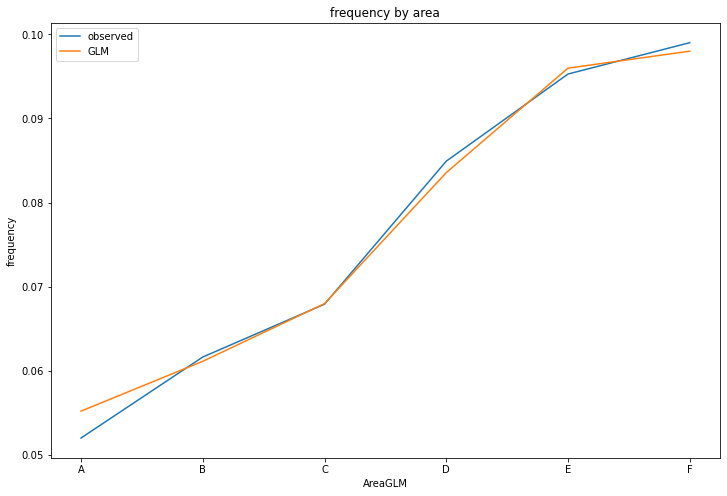

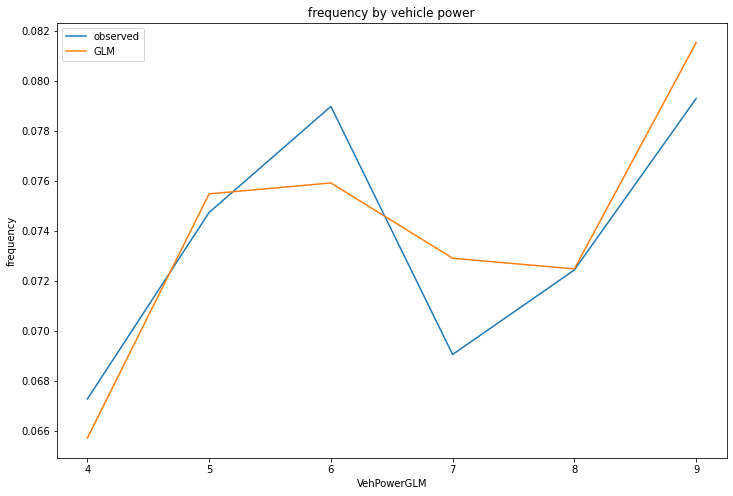

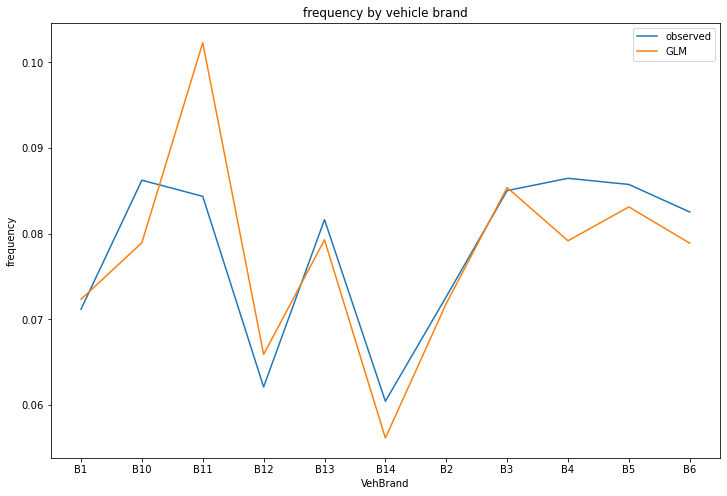

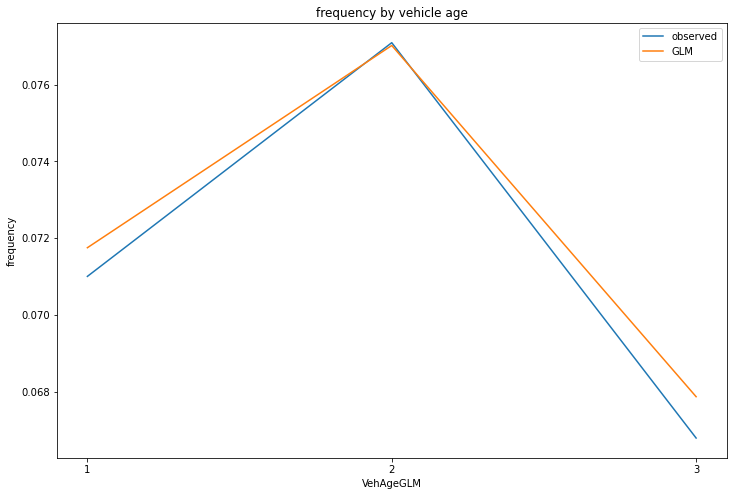

In [42]:
# Area
plot_freq(test, "AreaGLM", "frequency by area", "GLM", "fitGLM1")

# VehPower
plot_freq(test, "VehPowerGLM", "frequency by vehicle power", "GLM", "fitGLM1")

# VehBrand
plot_freq(test, "VehBrand", "frequency by vehicle brand", "GLM", "fitGLM1")

# VehAge
plot_freq(test, "VehAgeGLM", "frequency by vehicle age", "GLM", "fitGLM1")

In [43]:
new_row = {"model": "GLM1", 
           "run_time": round(glm1_time, 2), 
           "parameters": len(glm1.params), 
           "aic": round(glm1.aic, 2), 
           "in_sample_loss": round(poi_dev_train, 4), 
           "out_sample_loss": round(poi_dev_test, 4), 
           "avg_freq": round(avg_freq, 4)}

df_cmp = df_cmp.append(new_row, ignore_index = True)

/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/2653873180.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cmp = df_cmp.append(new_row, ignore_index = True)


## 3.5 GLM2 (drop feature component Area compared to GLM1)

### 3.5.1 Fitting

In [44]:
glm2_formula = '''
    ClaimNb ~ VehPowerGLM + VehAgeGLM + DrivAgeGLM + BonusMalusGLM + VehBrand + VehGas + DensityGLM + Region
'''

In [45]:
start = timeit.default_timer()
glm2 = smf.glm(formula = glm2_formula, 
               data = train, 
               family=sm.families.Poisson(), 
               offset = np.log(train["Exposure"])).fit()
finish = timeit.default_timer()
glm2_time = finish - start

In [46]:
print(glm2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542013
Model:                            GLM   Df Residuals:                   541965
Model Family:                 Poisson   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85854.
Date:                Mon, 20 Jun 2022   Deviance:                   1.3106e+05
Time:                        14:26:24   Pearson chi2:                 9.12e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01106
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.4626      0.08

### 3.5.2 Validation

In [47]:
#predictions
train["fitGLM2"] = glm2.fittedvalues

test["fitGLM2"] = glm2.predict(test, offset = np.log(test["Exposure"]))

dat["fitGLM2"] = glm2.predict(dat2, offset = np.log(dat2["Exposure"]))

/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/3797034301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["fitGLM2"] = glm2.fittedvalues
/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/3797034301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["fitGLM2"] = glm2.predict(test, offset = np.log(test["Exposure"]))


In [48]:
poi_dev_train = poisson_deviance(train["fitGLM2"], train["ClaimNb"])

poi_dev_test = poisson_deviance(test["fitGLM2"], test["ClaimNb"])

avg_freq = sum(test["fitGLM2"]) / sum(test["Exposure"])

In [49]:
print("100 x Poisson deviance GLM (train): %.5lf" % poi_dev_train)

print("100 x Poisson deviance GLM (test): %.5lf" % poi_dev_test)

print("average frequency (test): %.6lf" % avg_freq)

100 x Poisson deviance GLM (train): 24.18004
100 x Poisson deviance GLM (test): 23.85926
average frequency (test): 0.073998


### 3.5.3 Calibration

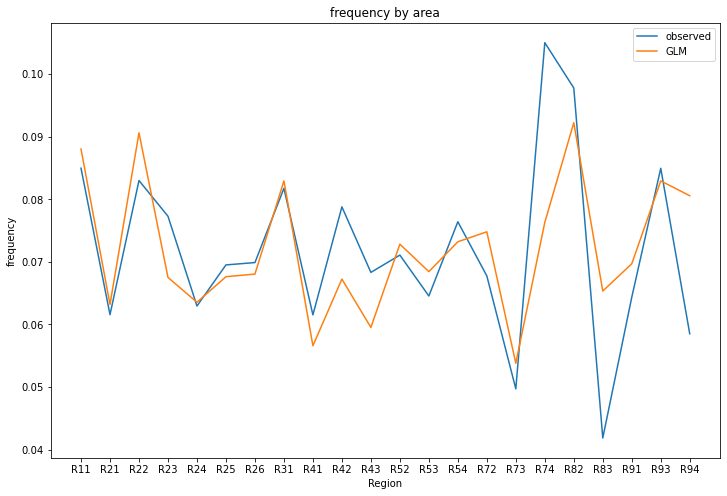

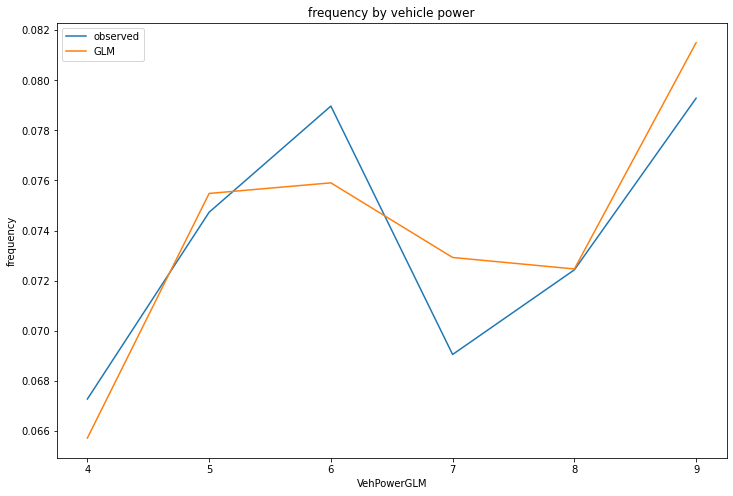

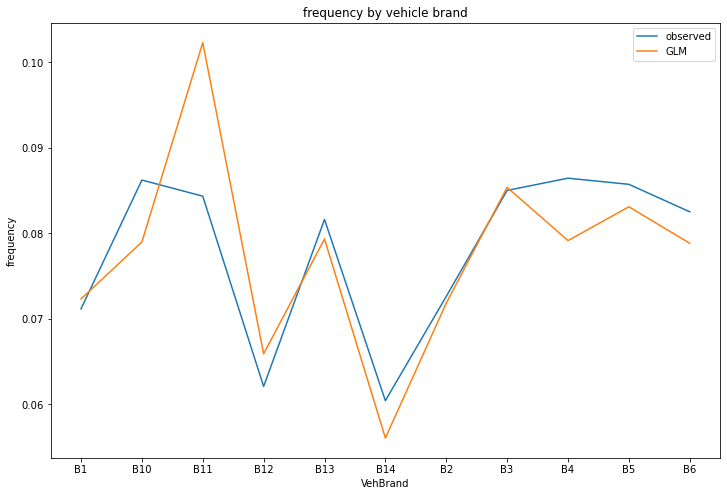

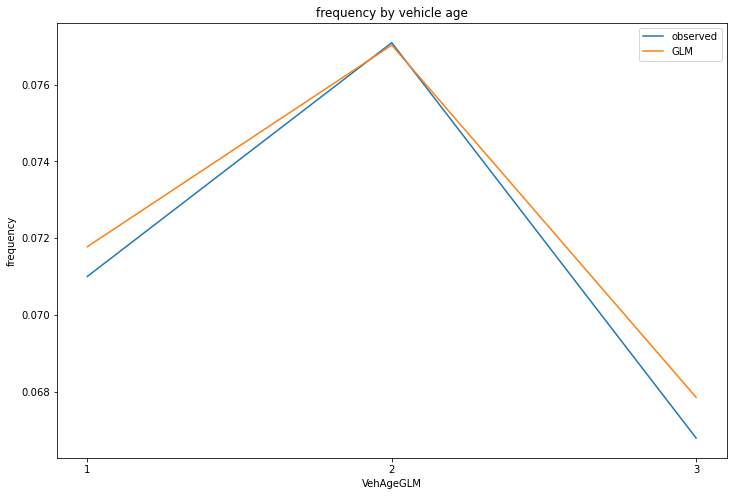

In [50]:
# Area
plot_freq(test, "Region", "frequency by area", "GLM", "fitGLM2")

# VehPower
plot_freq(test, "VehPowerGLM", "frequency by vehicle power", "GLM", "fitGLM2")

# VehBrand
plot_freq(test, "VehBrand", "frequency by vehicle brand", "GLM", "fitGLM2")

# VehAge
plot_freq(test, "VehAgeGLM", "frequency by vehicle age", "GLM", "fitGLM2")

In [51]:
new_row = {"model": "GLM2", 
           "run_time": round(glm2_time, 2), 
           "parameters": len(glm2.params), 
           "aic": round(glm2.aic, 2), 
           "in_sample_loss": round(poi_dev_train, 4), 
           "out_sample_loss": round(poi_dev_test, 4), 
           "avg_freq": round(avg_freq, 4)}

df_cmp = df_cmp.append(new_row, ignore_index = True)

/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/4209296875.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cmp = df_cmp.append(new_row, ignore_index = True)


## 3.6 GLM3 (drop feature components Area and VehBrand compared to GLM1)

### 3.6.1 Fitting

In [52]:
glm3_formula = "ClaimNb ~ VehPowerGLM + VehAgeGLM + DrivAgeGLM + BonusMalusGLM + VehGas + DensityGLM + Region"

In [53]:
start = timeit.default_timer()
glm3 = smf.glm(formula = glm3_formula, 
               data = train, 
               family=sm.families.Poisson(), 
               offset = np.log(train["Exposure"])).fit()
finish = timeit.default_timer()
glm3_time = finish - start

In [54]:
print(glm3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542013
Model:                            GLM   Df Residuals:                   541975
Model Family:                 Poisson   Df Model:                           37
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85958.
Date:                Mon, 20 Jun 2022   Deviance:                   1.3127e+05
Time:                        14:26:34   Pearson chi2:                 9.06e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01068
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.6257      0.08

### 3.6.2 Validation

In [55]:
#predictions
train["fitGLM3"] = glm3.fittedvalues

test["fitGLM3"] = glm3.predict(test, offset = np.log(test["Exposure"]))

dat["fitGLM3"] = glm3.predict(dat2, offset = np.log(dat2["Exposure"]))

/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/3389495857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["fitGLM3"] = glm3.fittedvalues
/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/3389495857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["fitGLM3"] = glm3.predict(test, offset = np.log(test["Exposure"]))


In [56]:
poi_dev_train = poisson_deviance(train["fitGLM3"], train["ClaimNb"])

poi_dev_test = poisson_deviance(test["fitGLM3"], test["ClaimNb"])

avg_freq = sum(test["fitGLM3"]) / sum(test["Exposure"])

In [57]:
print("100 x Poisson deviance GLM (train): %.5lf" % poi_dev_train)

print("100 x Poisson deviance GLM (test): %.5lf" % poi_dev_test)

print("average frequency (test): %.6lf" % avg_freq)

100 x Poisson deviance GLM (train): 24.21852
100 x Poisson deviance GLM (test): 23.90604
average frequency (test): 0.074003


### 3.6.3 Calibration

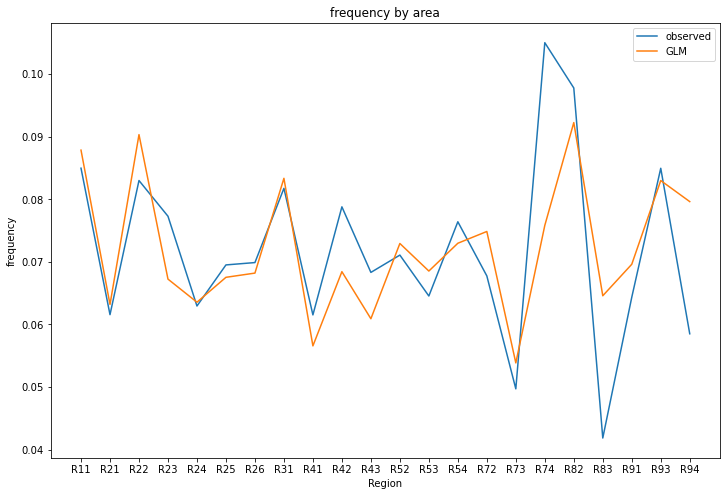

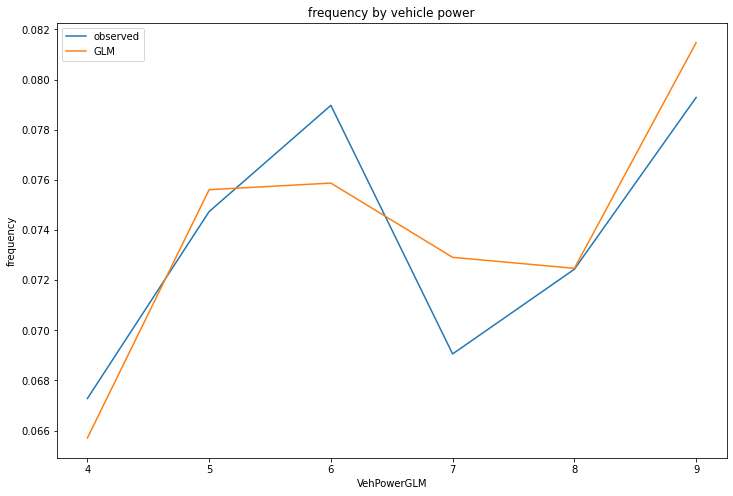

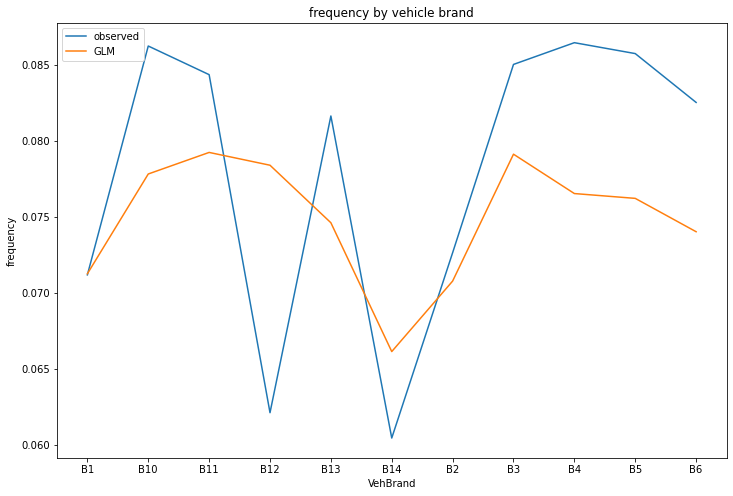

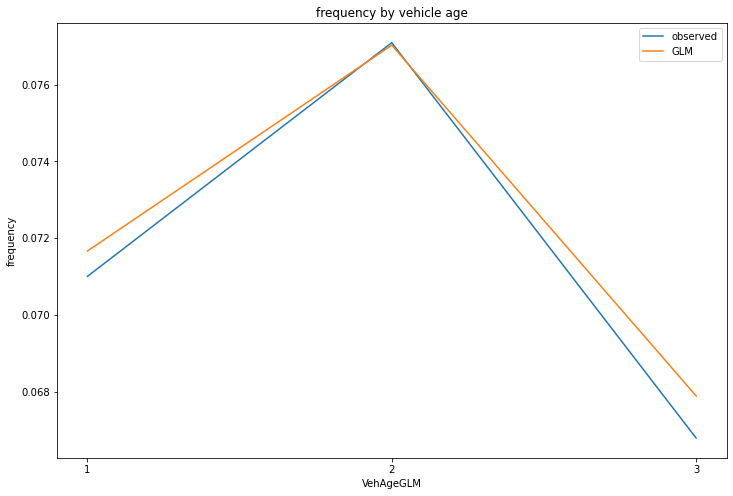

In [58]:
# Area
plot_freq(test, "Region", "frequency by area", "GLM", "fitGLM3")

# VehPower
plot_freq(test, "VehPowerGLM", "frequency by vehicle power", "GLM", "fitGLM3")

# VehBrand
plot_freq(test, "VehBrand", "frequency by vehicle brand", "GLM", "fitGLM3")

# VehAge
plot_freq(test, "VehAgeGLM", "frequency by vehicle age", "GLM", "fitGLM3")

In [59]:
new_row = {"model": "GLM3", 
           "run_time": round(glm3_time, 2), 
           "parameters": len(glm3.params), 
           "aic": round(glm3.aic, 2), 
           "in_sample_loss": round(poi_dev_train, 4), 
           "out_sample_loss": round(poi_dev_test, 4), 
           "avg_freq": round(avg_freq, 4)}

df_cmp = df_cmp.append(new_row, ignore_index = True)

/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/1337779401.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cmp = df_cmp.append(new_row, ignore_index = True)


# 4 Model Comparison

## 4.1 Comparing metrics

We have fitted three different models, as follows:

![figure_glms](glm/Figure_glms.PNG)

We present the results of these three models below. These results are obtained by first fitting the three models to the learning data set $\mathcal{D}$, which provides the corresponding MLEs. These MLEs are then used to calculate the in-sample loss on $\mathcal{D}$. The fitted model is then applied to the testing data set $\mathcal{T}$, which provides the out-of-sample loss.

In [60]:
df_cmp

,model,run_time,parameters,aic,in_sample_loss,out_sample_loss,avg_freq
0,GLM0,0.36,1,177736.58,25.2921,24.9989,0.0736
1,GLM1,11.16,53,171806.03,24.1787,23.8591,0.074
2,GLM2,8.89,48,171803.31,24.18,23.8593,0.074
3,GLM3,6.11,38,171991.91,24.2185,23.906,0.074


We can draw the following conclusions:

- The first observation from the table is that the in-sample loss is smaller than the out-of-sample loss. Of course, this is not surprising because we fit on the learning data, but if this difference is too big, this may either be a sign of over-fitting or a sign that learning and test data are rather different. If the in-sample loss is larger than the out-of-sample loss, it is an indication that there are some rows which belong together and are present in both datasets.
- As stated above, the split into train and test data is highly critical in practice and is an often encountered error.
- Considering Akaike's information criterion (AIC), which introduces a penalty term for over-fitting (to mimic an out-of-sample loss), the model with the smallest AIC value should be preferred. In our case, AIC (slightly) prefers Model GLM1. However, this model has a worse out-of-sample performance than Model GLM2. Thus, we do not get a clear (and good) advise from AIC and our out-of-sample analysis here, and for later purposes we will stick to Model GLM1 as benchmark model. Note that Model GLM3 is not competitive, and the component $\texttt{VehBrand}$ is needed, in particular, for car brand $\texttt{B12}$.

## 4.2 Comparing predicted claim frequency by feature level

In this section, we are going to compare the predicted claim frequency split by features. This is similar to the calibration charts above and allows a visual comparison of the models.

In [61]:
def plot_freq_2(xvar, title):
    
    sum_out = test.groupby(xvar).agg(
        sum_claimNb = pd.NamedAgg(column = "ClaimNb", aggfunc = sum),
        sum_exposure = pd.NamedAgg(column = "Exposure", aggfunc = sum),
        sum_1 = pd.NamedAgg(column = "fitGLM1", aggfunc = sum),
        sum_2 = pd.NamedAgg(column = "fitGLM2", aggfunc = sum),
        sum_3 = pd.NamedAgg(column = "fitGLM3", aggfunc = sum)
    )
    
    out = pd.DataFrame()
    out["obs"] = sum_out["sum_claimNb"] / sum_out["sum_exposure"]
    out["glm1"] = sum_out["sum_1"] / sum_out["sum_exposure"]
    out["glm2"] = sum_out["sum_2"] / sum_out["sum_exposure"]
    out["glm3"] = sum_out["sum_3"] / sum_out["sum_exposure"]

    
    plt.figure(figsize=(12,8))
    
    plt.plot(out.index, out["obs"], label = "observed")
    plt.plot(out.index, out["glm1"], label = "GLM1")
    plt.plot(out.index, out["glm2"], label = "GLM2")
    plt.plot(out.index, out["glm3"], label = "GLM3")
    plt.title(title)
    plt.xlabel(xvar)
    plt.ylabel("frequency")
    plt.legend()
    plt.ylim((0, 0.2))
    plt.show()

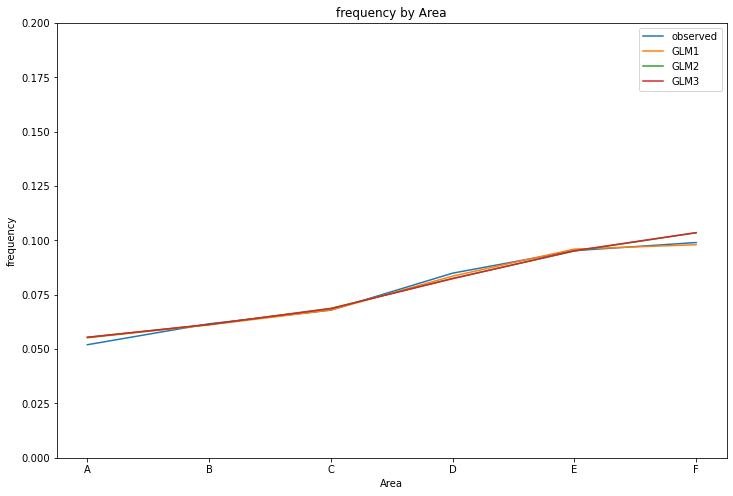

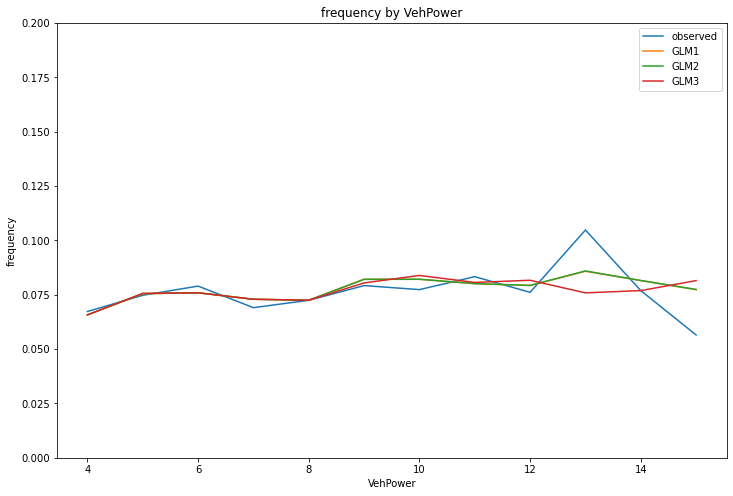

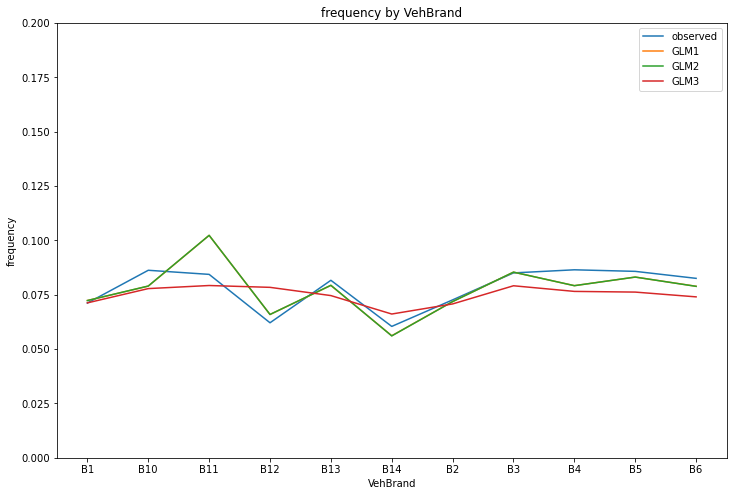

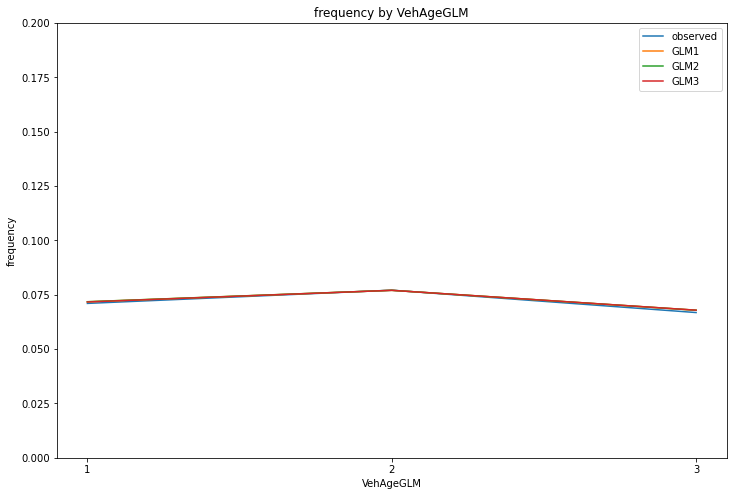

In [62]:
# Area
plot_freq_2("Area", "frequency by Area")

# VehPower
plot_freq_2("VehPower", "frequency by VehPower")

# VehBrand
plot_freq_2("VehBrand", "frequency by VehBrand")

# VehAgeGLM
plot_freq_2("VehAgeGLM", "frequency by VehAgeGLM")

The charts show that the predictions for area are very close for all models. For vehicle power, the models are similar but they deviate from the observation. 

We can conclude that all models provide very similar predictions, hence the best model selected above should be used.

## 4.3 Comparing individual predicted claim frequency

Below we compare the out-of-sample claim frequency predictions (on log-scales) for two models. It allows to (maybe) identify if there are areas in the feature space where the predicted claim frequencies differ more/less than in other areas of the feature space.


In [63]:
axis_max = np.log(max(test["fitGLM1"].append(test["fitGLM2"])))
axis_min = np.log(min(test["fitGLM1"].append(test["fitGLM2"])))

/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/707185989.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  axis_max = np.log(max(test["fitGLM1"].append(test["fitGLM2"])))
/var/folders/sq/__n07d014s3gvhj5fy8b61zr0000gn/T/ipykernel_30063/707185989.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  axis_min = np.log(min(test["fitGLM1"].append(test["fitGLM2"])))


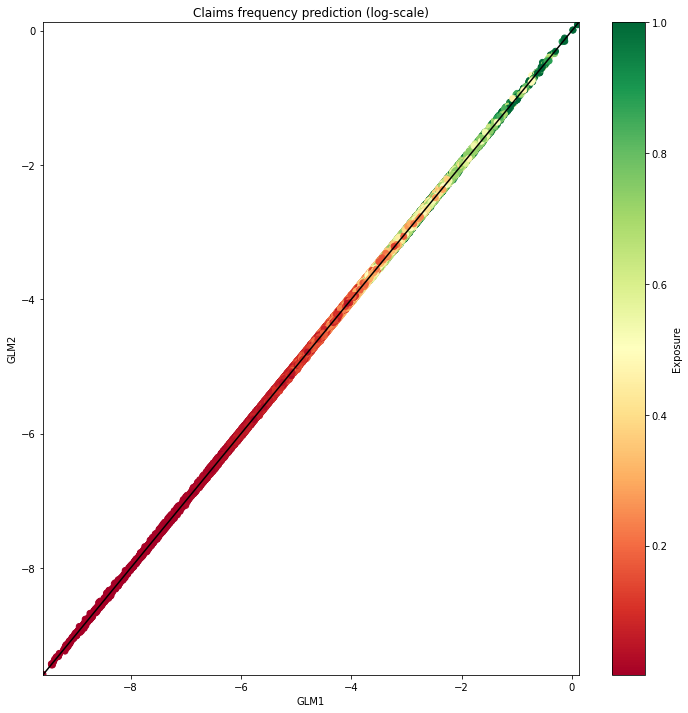

In [64]:
fig, ax = plt.subplots(figsize=(12,12))
glm_1_2 = plt.scatter(np.log(test["fitGLM1"]), np.log(test["fitGLM2"]), c = test["Exposure"], cmap = "RdYlGn")
ax.axline((0, 0), slope=1, color = "black")
plt.xlim((axis_min, axis_max))
plt.ylim((axis_min, axis_max))
plt.xlabel("GLM1")
plt.ylabel("GLM2")
plt.title("Claims frequency prediction (log-scale)")
plt.colorbar(glm_1_2, label = "Exposure")
plt.show()

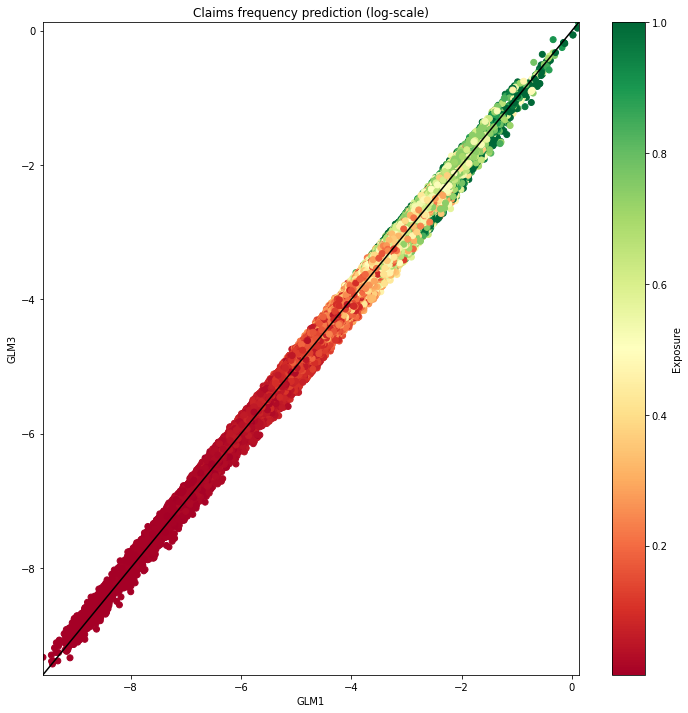

In [65]:
fig, ax = plt.subplots(figsize=(12,12))
glm_1_3 = plt.scatter(np.log(test["fitGLM1"]), np.log(test["fitGLM3"]), c = test["Exposure"], cmap = "RdYlGn")
ax.axline((0, 0), slope=1, color = "black")
plt.xlim((axis_min, axis_max))
plt.ylim((axis_min, axis_max))
plt.xlabel("GLM1")
plt.ylabel("GLM3")
plt.title("Claims frequency prediction (log-scale)")
plt.colorbar(glm_1_3, label = "Exposure")
plt.show()